# Guide on how to use the backtester

In [1]:
# Ensure the project root is in PATH.
import sys

sys.path.append("../")
# All imports of our code are relative to the project root.

from backtester.backtester import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sys
import os

This is the implementation of our trader

In [2]:
class Trader:
    def __init__(self):
        self.position_limit = {"KELP": 50, "RAINFOREST_RESIN": 50}
        pass

    def take_best_orders(self, state: TradingState, orderbook: OrderDepth) -> list[Order]:
        orders: list[Order] = []

        symbol = "RAINFOREST_RESIN"
        position = state.position[symbol] if symbol in state.position else 0

        max_buy_amount = self.position_limit[symbol] - position
        max_sell_amount = abs(-self.position_limit[symbol] - position)

        if len(orderbook.buy_orders) != 0:
            best_bid_price = max(orderbook.buy_orders.keys())
            best_bid_volume = orderbook.buy_orders[best_bid_price]

            if best_bid_price > 10000:
                fill_quantity = min(max_sell_amount, best_bid_volume)

                if fill_quantity > 0:
                    orders.append(Order(symbol, best_bid_price, -fill_quantity))
                    del orderbook.buy_orders[best_bid_price]

        if len(orderbook.sell_orders) != 0:
            best_ask_price = min(orderbook.sell_orders.keys())
            best_ask_volume = abs(orderbook.sell_orders[best_ask_price])

            if best_ask_price < 10000:
                fill_quantity = min(max_buy_amount, best_ask_volume)

                if fill_quantity > 0:
                    orders.append(Order(symbol, best_ask_price, fill_quantity))
                    del orderbook.sell_orders[best_ask_price]

        return orders

    def run(self, state: TradingState):
        result = {}
        for product in state.order_depths:
            orders: list[Order] = []

            if product == "RAINFOREST_RESIN":
                took = self.take_best_orders(state, state.order_depths[product])

                while len(took) != 0:
                    orders = orders + took
                    took = self.take_best_orders(state, state.order_depths[product])

            result[product] = orders
        traderData = "SAMPLE"  # String value holding Trader state data required. It will be delivered as TradingState.traderData on next execution.

        conversions = 1
        return result, conversions, traderData

Copy paste these below lines whenever you want to access the historical data. These have datatype `pd.Dataframe`.  

If you want all 3 days combined into 1, then copy the code for `market_data_all3days` and `trades_all3days`. You can't just `pd.concat()` them all because the backtester doesn't consider day.

In [3]:
market_data_round_3_day_0 = pd.read_csv(os.path.join("..", "data", "round3", "prices_round_3_day_0.csv"), sep=";")
market_data_round_3_day_1 = pd.read_csv(os.path.join("..", "data", "round3", "prices_round_3_day_1.csv"), sep=";")
market_data_round_3_day_2 = pd.read_csv(os.path.join("..", "data", "round3", "prices_round_3_day_2.csv"), sep=";")

trades_round_3_day_0 = pd.read_csv(os.path.join("..", "data", "round3", "trades_round_3_day_0.csv"), sep=";")
trades_round_3_day_1 = pd.read_csv(os.path.join("..", "data", "round3", "trades_round_3_day_1.csv"), sep=";")
trades_round_3_day_2 = pd.read_csv(os.path.join("..", "data", "round3", "trades_round_3_day_2.csv"), sep=";")



# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output


market_data_round_3_all3days = concatenate_historical_data([market_data_round_3_day_0, market_data_round_3_day_1, market_data_round_3_day_2])
trades_round_3_all3days = concatenate_historical_data([trades_round_3_day_0, trades_round_3_day_1, market_data_round_3_day_2])

Lets run the backtester

In [4]:
# 1. Define the listings. (optimisation - only define symbols we are trading)
listings = {
    # "CROISSANTS": Listing(symbol="CROISSANTS", product="CROISSANTS", denomination="SEASHELLS"),
    # "DJEMBES": Listing(symbol="DJEMBES", product="DJEMBES", denomination="SEASHELLS"),
    # "JAMS": Listing(symbol="JAM", product="JAM", denomination="SEASHELLS"),
    # "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),
    # "PICNIC_BASKET1": Listing(symbol="PICNIC_BASKET1", product="PICNIC_BASKET1", denomination="SEASHELLS"),
    # "PICNIC_BASKET2": Listing(symbol="PICNIC_BASKET2", product="PICNIC_BASKET2", denomination="SEASHELLS"),
    "RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),
    # "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK": Listing(symbol="VOLCANIC_ROCK", product="VOLCANIC_ROCK", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10000": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10000", product="VOLCANIC_ROCK_VOUCHER_10000", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10250": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10250", product="VOLCANIC_ROCK_VOUCHER_10250", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10500", product="VOLCANIC_ROCK_VOUCHER_10500", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_9500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9500", product="VOLCANIC_ROCK_VOUCHER_9500", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_9750": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9750", product="VOLCANIC_ROCK_VOUCHER_9750", denomination="SEASHELLS"),
}

# 2. Define the position limits. (optimisation - only define symbols we are trading)
position_limit = {
    # "CROISSANTS": 250,
    # "DJEMBES": 60,
    # "JAMS": 350,
    # "KELP": 50,
    # "PICNIC_BASKET1": 60,
    # "PICNIC_BASKET2": 100,
    "RAINFOREST_RESIN": 50,
    # "SQUID_INK": 50,
    # "VOLCANIC_ROCK": 400,
    # "VOLCANIC_ROCK_VOUCHER_10000": 200,
    # "VOLCANIC_ROCK_VOUCHER_10250": 200,
    # "VOLCANIC_ROCK_VOUCHER_10500": 200,
    # "VOLCANIC_ROCK_VOUCHER_9500": 200,
    # "VOLCANIC_ROCK_VOUCHER_9750": 200,
}


# 4. Market data and trade history files. (look at the previous cell)

# 5. Instantiate Trader object
trader = Trader()

# 6. Instantiate Backtester object
bt = Backtester(trader, listings, position_limit, market_data_round_3_day_0, trades_round_3_day_0)


bt.run()


# double layer dictionary.
resinpnl = bt.pnl()["spreadcrossing"]["RAINFOREST_RESIN"]
totalpnl = bt.pnl()["spreadcrossing"]["total"]
resinpnl, totalpnl, bt.pnl()

(10042.0,
 10042.0,
 {'spreadcrossing': {'RAINFOREST_RESIN': 10042.0, 'total': 10042.0},
  'midpoint': {'RAINFOREST_RESIN': 23328.0, 'total': 23328.0}})

You can copy paste everything, except for the Trader algo, which should be whatever algo you wish to backtest.

Let's look at some metrics now.

Note:
- `get_metric` function is now deleted.
- `bt.pnl` is also deleted.
- If you want metrics, use `calculate_metrics(product)`.

Old way:
    bt.get_metric('midpoint_sharpe', 'KELP')

New way:
    metrics = bt.calculate_metrics('KELP')
    metric = metrics['midpoint_sharpe']

Available metrics: dict_keys(['timestamp', 'spreadcrossing_pnl', 'spreadcrossing_final_pnl', 'spreadcrossing_sharpe', 'spreadcrossing_pnl_bps', 'midpoint_pnl', 'midpoint_final_pnl', 'midpoint_sharpe', 'midpoint_pnl_bps'])


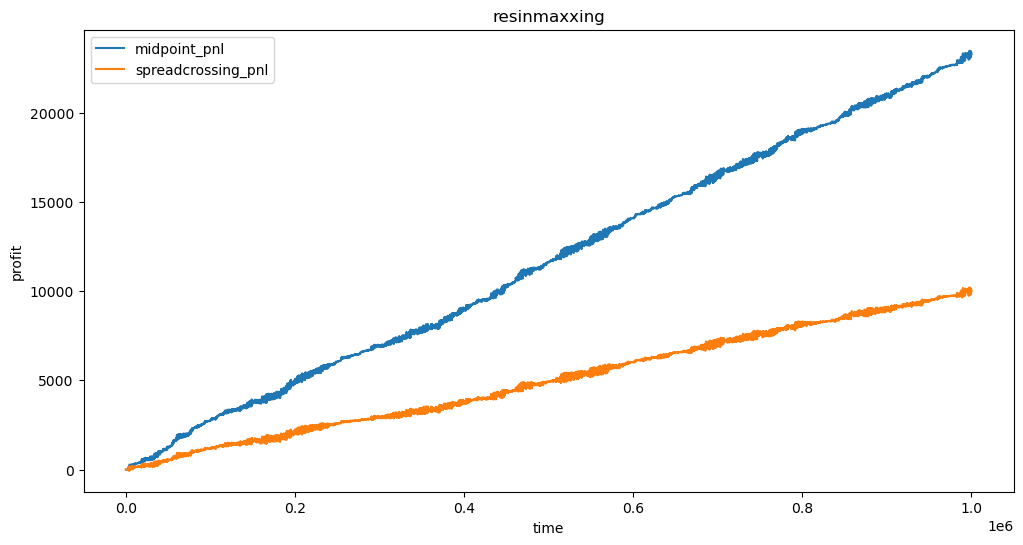

In [5]:
metrics = bt.calculate_metrics("RAINFOREST_RESIN")

print(f"Available metrics: {metrics.keys()}")

# metrics['timestamp'] is provided for convenience.
# this should line up with metrics['midpoint_pnl'] and metrics['spreadcrossing_pnl'] (i.e. same shape)

plt.figure(figsize=(12, 6))
plt.plot(metrics["timestamp"], metrics["midpoint_pnl"], label="midpoint_pnl")
plt.plot(metrics["timestamp"], metrics["spreadcrossing_pnl"], label="spreadcrossing_pnl")
plt.title("resinmaxxing")
plt.xlabel("time")
plt.ylabel("profit")
plt.legend()